In [5]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
%matplotlib inline

# <centeR>Estimating regression coefficients</centeR>

We begin today where we left off in Day32. We have random variables $X,Y$, we assume some function form for the conditional expectation $E[Y|X=x]$. Here we assume that the conditional expectation is linear, so that if we decompose $Y$ as we did in the lecture, we get this

$$Y = b_0 + b_1X + \epsilon$$

This is a theoretical quantity that we have to estimate. So our task is to estimate the parameters of this function ($b_0, b_1$, here), which we can do by minimizing the empirical squared error.




#### <centeR>Today's question: When can we accurately estimate the **regression coefficients** $b_0$ and $b_1$?

In particular, we'll see that the answer depends on two things (among many others!):

+ How good is the quality of our data?

+ Do we have all the variables we need?

---

## Part 1: Good Data, Bad Data

I'd like you to have a good intuition for what kind of data is favorable for estimation.

The function `generate_data` below takes a number of observations and a variance for the error term and generates some data (duh).

In [6]:
def generate_data(n_obs, sigma_e):
    X = ss.uniform(0, 10).rvs(n_obs) # n_obs draws from the Uniform[0, 10] distribution
    e = ss.norm(0, sigma_e).rvs(n_obs)  # error term e ~ Normal(0, sigma_e^2)
    Y = 2 + 3*X + e
    return X, Y

In [25]:
x, y = generate_data(10000, 1)

This is how you'd plot a quick scatterplot of $x$-$y$.

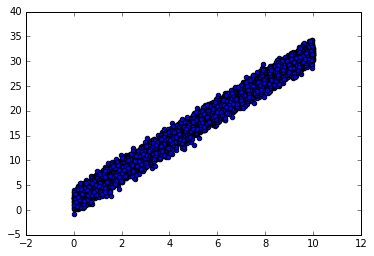

In [26]:
fig, ax = plt.subplots(1)  # Creates a new plotting window
ax.scatter(x, y)           # Draws the scatterplot

Discussion:
    
+ How does $\sigma_e$ affect the distribution of Y|X?

+ How do you think $n$ and $\sigma_e$ will affect the distribution of $\hat{b}_0$ and $\hat{b}_1$?

---

### Estimating linear regression coefficients

We'll use the library `statsmodels` (it's last new library of the course, I promise!).

In [31]:
import statsmodels.api as sm  

Its not very hard to use! First, fit the line

In [34]:
x

array([ 9.85727279,  2.77870306,  5.00928265, ...,  4.02801252,
        8.76673125,  2.48789296])

In [33]:
xx

array([[ 1.        ,  9.85727279],
       [ 1.        ,  2.77870306],
       [ 1.        ,  5.00928265],
       ..., 
       [ 1.        ,  4.02801252],
       [ 1.        ,  8.76673125],
       [ 1.        ,  2.48789296]])

In [35]:
xx = sm.add_constant(x)
results = sm.OLS(y, xx).fit()

The `results` variable contains all the information about the problem: the data, the estimated coefficients, a bunch of test results, auxiliary functions, etc.

Let's see a summary of results:

In [30]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.987
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                 7.659e+05
Date:                Fri, 18 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:20:21   Log-Likelihood:                -14119.
No. Observations:               10000   AIC:                         2.824e+04
Df Residuals:                    9998   BIC:                         2.826e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.9993      0.020    101.578      0.000         1.961     2.038
x1             3.0028      0.003    875.186      0.000         2.996     3.010
==============================================================================
Omnibus:                        2.046   Durbin-Watson:                   1.995
Prob(Omnibus):                  0.359   Jarque-Bera (JB):                2.008
Skew:                          -0.031   Prob(JB):                        0.366
Kurtosis:                       3.032   Cond. No.                         11.6
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

You'll learn what the items in the top table are about in Econometrics. 

Today's we'll focus on the middle table. 

(The bottom table I don't understand either :P)

#### Table columns

+ **coef**: This column contains the $b_0, b_1$ coefficients. Their true values are $b_0 = 2$ and $b_1 = 3$.

+ **std err**: That's the standard deviation of the estimated coefficients $\hat{b}_0, \hat{b}_1$.

+ **t**: That's the t-statistic associated with $\hat{b}$, i.e., $\hat{t} = \frac{\hat{b} - b}{\sqrt{\frac{\hat{\sigma}^2}{n}}}$

+ **P>|t|**: this is the p-value associated with the estimated coefficients. By default, the null hypothesis is $H_0: \hat{b} = 0$.

+ **[95.0% Conf. Int.]**: Self-explanatory.

### Discussion

+ Generate data again with different $n$ but same $\sigma_e$, then keep $n$ the same but increase $\sigma_e$. 
    + What happens to the **std err** column?
    + What happens to the **p-value** and **[95.0% Conf. Int.]** columns?
    

+ Why do you think it's convenient to have a default null hypothesis $H_0: \hat{b} = 0$ for each coefficient?

---

## Part 2: *Ommited Variable Bias*

Ok, now let's generate another data set, but now there will be two **correlated** regressors: `X1` and `X2`.

In [65]:
def generate_data_2d(n_obs, sigma_e):
    X = ss.multivariate_normal([5, 5], [[2,1],[1,2]]).rvs(n_obs) # X has two columns (representing X1, X2)
    e = ss.norm(0, sigma_e).rvs(n_obs)  # error term e ~ Normal(0, sigma_e^2)
    Y = 2 + 3*X[:,0] - 6*X[:,1] + e
    return X, Y

In [66]:
x, y = generate_data_2d(100000, 1)

The only thing to notice is that now `x` is an array with two columns:

In [67]:
x[:5, :]  # First 5 rows

array([[ 5.93705735,  5.86251603],
       [ 6.47176166,  4.7061323 ],
       [ 4.22551555,  5.8020791 ],
       [ 7.67883596,  6.6248719 ],
       [ 5.10721248,  4.58303531]])

The regression syntax is the same

In [68]:
xx = sm.add_constant(x)
results = sm.OLS(y, xx).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.982
Model:                            OLS   Adj. R-squared:                  0.982
Method:                 Least Squares   F-statistic:                 2.714e+06
Date:                Fri, 18 Nov 2016   Prob (F-statistic):               0.00
Time:                        15:37:16   Log-Likelihood:            -1.4157e+05
No. Observations:              100000   AIC:                         2.831e+05
Df Residuals:                   99997   BIC:                         2.832e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.0041      0.013    151.614      0.000         1.978     2.030
x1             3.0024      0.003   1165.486      0.000         2.997     3.007
x2            -6.0019      0.003  -2329.995      0.000        -6.007    -5.997
==============================================================================
Omnibus:                        2.294   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.318   Jarque-Bera (JB):                2.296
Skew:                          -0.012   Prob(JB):                        0.317
Kurtosis:                       2.998   Cond. No.                         31.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

So far, so good? Now *let's break it*. 

Let's redo the regression, but now we'll "forget" to regress on the second regressor. 

We say that $X_2$ has been **ommitted**.

In [69]:
xx = sm.add_constant(x[:,0])  # TAKING ONLY THE FIRST COLUMN OF X!
results = sm.OLS(y, xx).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7880
Date:                Fri, 18 Nov 2016   Prob (F-statistic):              0.375
Time:                        15:37:21   Log-Likelihood:            -3.4220e+05
No. Observations:              100000   AIC:                         6.844e+05
Df Residuals:                   99998   BIC:                         6.844e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const        -12.9068      0.086   -150.077      0.000       -13.075   -12.738
x1            -0.0147      0.017     -0.888      0.375        -0.047     0.018
==============================================================================
Omnibus:                        4.972   Durbin-Watson:                   1.992
Prob(Omnibus):                  0.083   Jarque-Bera (JB):                4.970
Skew:                          -0.017   Prob(JB):                       0.0833
Kurtosis:                       3.001   Cond. No.                         19.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Discussion

+ How do the two coefficients associated with `x1` compare?

+ Why is the coefficient on `x1` larger this time? (We say it's **biased**)

+ Go back to the `generate_data_2d` function and increase the **magnitude** of coefficient on the second regressor. How do you think this set of results will change?

+ Go back to the `generate_data_2d` function and change the **sign** of the coefficient on the second regressor. How do you think this set of results will change?

+ What if $X_1$ and $X_2$ were **uncorrelated**?

+ How does this all relate to finding **causal effects**?